<a href="https://colab.research.google.com/github/manthanawgan/KarimganjAssamChapter_FloodPredictionandManagement/blob/main/Indirect_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "AllData_After_EDA.csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")



In [ ]:
df.describe()

,Date,rain_sum (mm),wind_speed_10m_max (m/s),wind_gusts_10m_max (m/s),wind_direction_10m_dominant (°),et0_fao_evapotranspiration (mm),Longai_discharge (m³/s),pressure_msl (hPa),soil_moisture_100_to_255cm (m³/m³),flooded,month,year
count,3654,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2020-01-01 11:59:59.999999744,9.425698,2.803503,6.740887,128.991516,3.183656,100.429540,1008.789381,0.486138,0.125068,6.520799,2019.501916
min,2015-01-01 00:00:00,0.000000,0.920000,3.000000,0.000000,0.440000,37.020000,992.200000,0.417000,0.000000,1.000000,2015.000000
25%,2017-07-02 06:00:00,0.000000,2.200000,4.800000,46.000000,2.510000,48.660000,1004.600000,0.464000,0.000000,4.000000,2017.000000
50%,2020-01-01 12:00:00,1.700000,2.560000,6.100000,86.000000,3.115000,79.720000,1009.100000,0.491000,0.000000,7.000000,2020.000000
75%,2022-07-02 18:00:00,12.600000,3.200000,8.100000,207.000000,3.850000,136.400000,1013.100000,0.511000,0.000000,10.000000,2022.000000
max,2025-01-01 00:00:00,193.100000,10.120000,20.500000,360.000000,6.930000,1591.210000,1019.800000,0.519000,1.000000,12.000000,2025.000000
std,NaN,16.915257,0.921590,2.453858,105.244328,1.017729,64.971843,5.122606,0.026042,0.330842,3.450083,2.874103


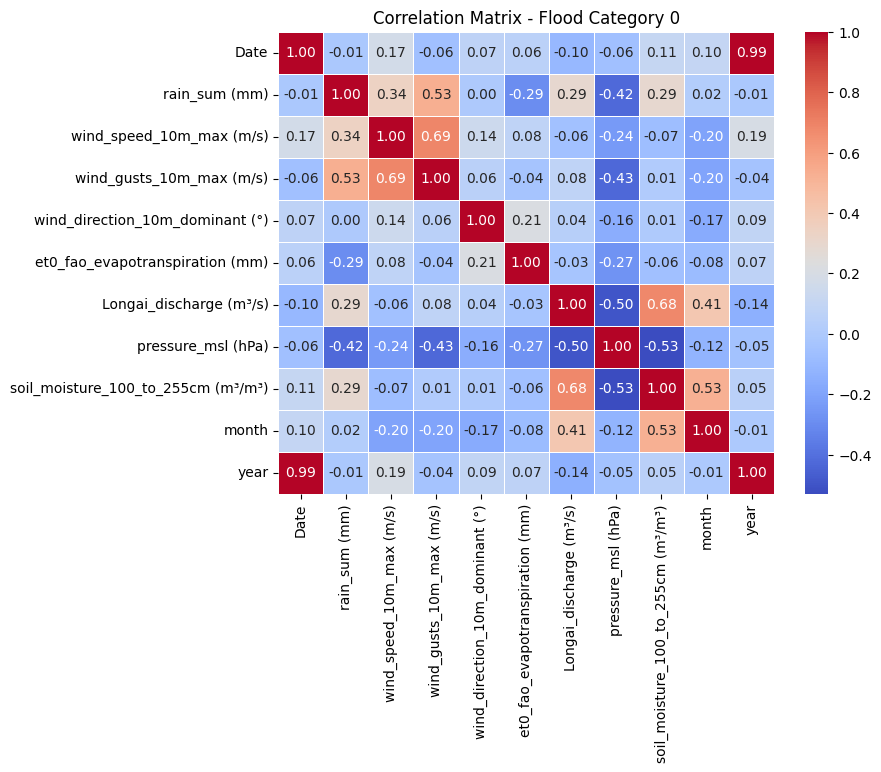

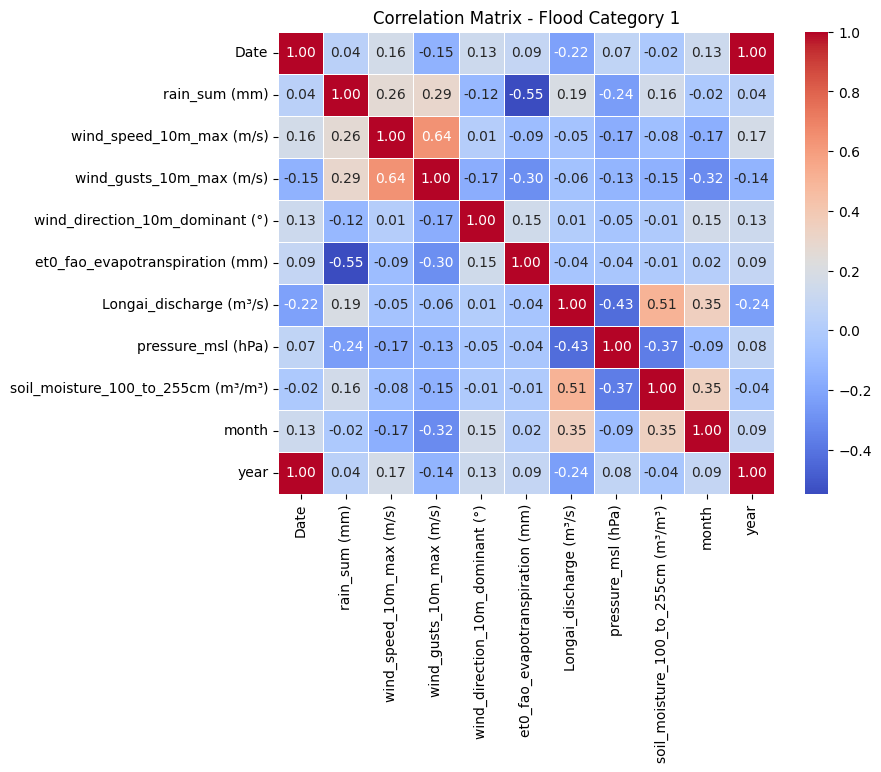

In [ ]:

# Compute correlation matrices for each category
correlation_matrices = {}
for label in sorted(df['flooded'].unique()):  # Loop over flood categories
    subset = df[df['flooded'] == label].drop(columns=['flooded'])  # Filter by label
    correlation_matrices[label] = subset.corr()

# Display correlation matrix for each category
for label, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(f"Correlation Matrix - Flood Category {label}")
    plt.show()


flooded                               1.000000
soil_moisture_100_to_255cm (m³/m³)    0.309622
Longai_discharge (m³/s)               0.235296
rain_sum (mm)                         0.217723
wind_gusts_10m_max (m/s)              0.185361
wind_speed_10m_max (m/s)              0.095214
wind_direction_10m_dominant (°)       0.049184
et0_fao_evapotranspiration (mm)       0.034829
month                                -0.020866
year                                 -0.050777
Date                                 -0.052760
pressure_msl (hPa)                   -0.370723
Name: flooded, dtype: float64


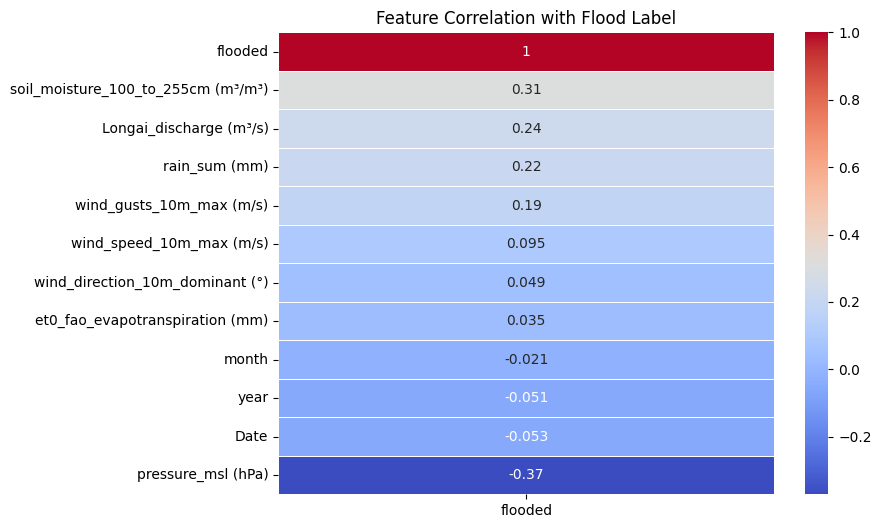

In [ ]:
# Compute correlation of features with the flood label
corr_with_label = df.corr()['flooded'].sort_values(ascending=False)

# Display correlations
print(corr_with_label)

# Plot correlation as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_with_label.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Flood Label")
plt.show()


In [ ]:
# Create lag features for rain_sum and Longai_discharge
df["rain_sum_lag1"] = df["rain_sum (mm)"].shift(1)
df["discharge_lag1"] = df["Longai_discharge (m³/s)"].shift(1)

# Drop initial rows with NaN due to lag features
df.dropna(inplace=True)

# Define features and target variables
features = [
    "rain_sum_lag1", "discharge_lag1",
    "wind_speed_10m_max (m/s)", "wind_gusts_10m_max (m/s)",
    "et0_fao_evapotranspiration (mm)", "pressure_msl (hPa)",
    "soil_moisture_100_to_255cm (m³/m³)", "month", "year"
]

# Targets: Predict rain_sum and discharge, then use those to predict flood probability
X = df[features]
y_rain = df["rain_sum (mm)"]
y_discharge = df["Longai_discharge (m³/s)"]
y_flood = df["flooded"]


In [ ]:
# Split data into training and testing sets
# Ensure at least 20% of the data is used for testing
train_size = int(len(df) * 0.8)  # 80% train, 20% test

# Properly split data
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_rain_train, y_rain_test = y_rain.iloc[:train_size], y_rain.iloc[train_size:]
y_discharge_train, y_discharge_test = y_discharge.iloc[:train_size], y_discharge.iloc[train_size:]
y_flood_train, y_flood_test = y_flood.iloc[:train_size], y_flood.iloc[train_size:]

# Verify the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 2922
Test set size: 731


# Train XGBoost models for rainfall and river discharge

In [ ]:
xgb_rain = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_rain.fit(X_train, y_rain_train)
y_rain_xgb_pred = xgb_rain.predict(X_test)

xgb_discharge = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_discharge.fit(X_train, y_discharge_train)
y_discharge_xgb_pred = xgb_discharge.predict(X_test)



In [ ]:
r2 = r2_score(y_rain_test, y_rain_xgb_pred)
mse = mean_squared_error(y_rain_test, y_rain_xgb_pred)
rmse = np.sqrt(mse)
print("Rain prediciton results")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
r2 = r2_score(y_discharge_test, y_discharge_xgb_pred)
mse = mean_squared_error(y_discharge_test, y_discharge_xgb_pred)
rmse = np.sqrt(mse)
print("River discharge prediciton results")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Rain prediciton results
Mean Squared Error (MSE): 158.3741
Root Mean Squared Error (RMSE): 12.5847
R² Score: 0.5034
River discharge prediciton results
Mean Squared Error (MSE): 3245.4551
Root Mean Squared Error (RMSE): 56.9689
R² Score: 0.6000


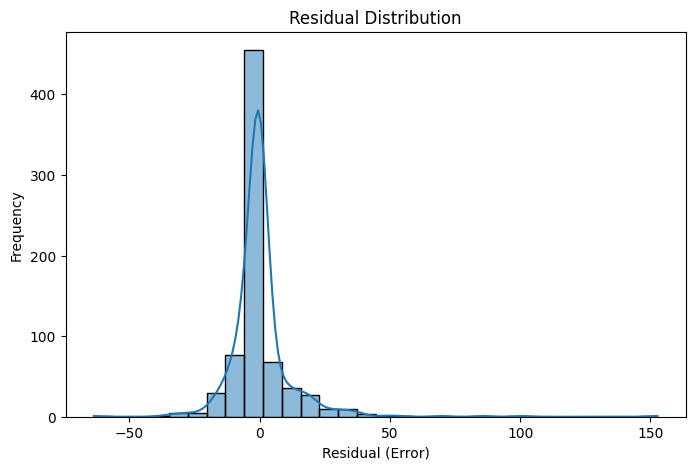

In [ ]:
residuals = y_rain_test - y_rain_xgb_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


Looking normal as it should :)

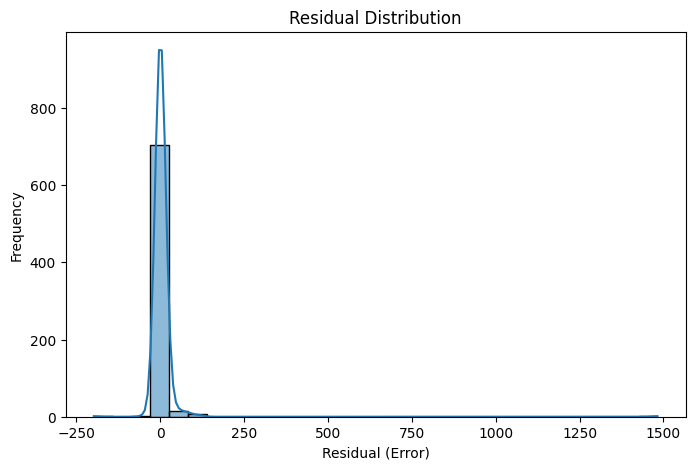

In [ ]:
residuals = y_discharge_test - y_discharge_xgb_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


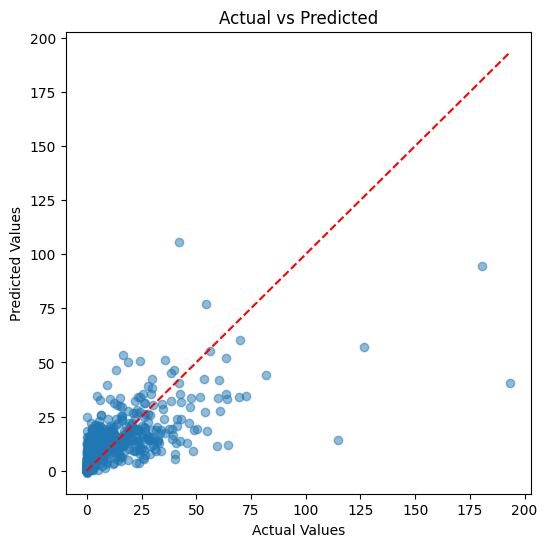

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_rain_test, y_rain_xgb_pred, alpha=0.5)
plt.plot([min(y_rain_test), max(y_rain_test)], [min(y_rain_test), max(y_rain_test)], color="red", linestyle="--")  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

We probably need to optimize the model for rain prediction

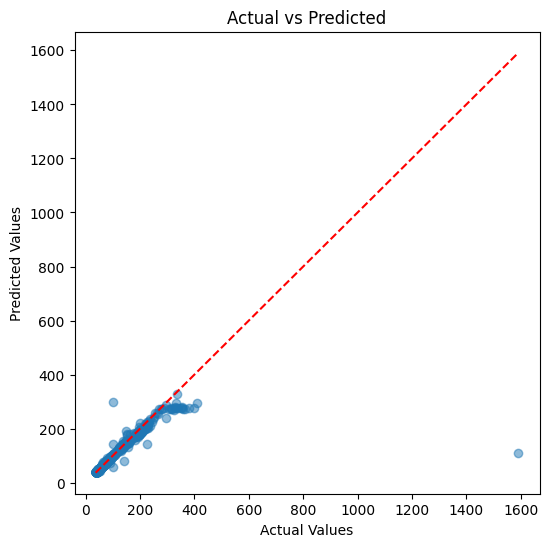

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_discharge_test, y_discharge_xgb_pred, alpha=0.5)
plt.plot([min(y_discharge_test), max(y_discharge_test)], [min(y_discharge_test), max(y_discharge_test)], color="red", linestyle="--")  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

River discharge prediction is looking great

# XGBoost flood classification model using the predicted rainfall and river discharge values:

In [ ]:

df_predictions = pd.DataFrame({
    'predicted_discharge': y_discharge_xgb_pred,
    'predicted_rain': y_rain_xgb_pred
}).reset_index(drop=True)  # Reset index

# Define flood classification function
def classify_flood(rain, discharge):
    if discharge <= 100 and rain <= 12:
        return 0  # No Flood
    elif (100 < discharge <= 100) or (12 < rain <= 100):
        return 1  # Mild Flood
    else:
        return 2  # Severe Flood

# Apply flood classification
df_predictions['flood_label'] = df_predictions.apply(
    lambda row: classify_flood(row['predicted_rain'], row['predicted_discharge']), axis=1
)

# Features and target
X_flood = df_predictions[['predicted_discharge', 'predicted_rain']]
y_flood = df_predictions['flood_label']

# Ensure chronological order
train_size = int(len(df_predictions) * 0.7)  # 80% train, 20% test

# Use a time-based split
X_flood_train, X_flood_test = X_flood.iloc[:train_size], X_flood.iloc[train_size:]
y_flood_train, y_flood_test = y_flood.iloc[:train_size], y_flood.iloc[train_size:]

# Train XGBoost classifier
xgb_flood = XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=5)
xgb_flood.fit(X_flood_train, y_flood_train)

# Predict flood probability
y_flood_pred = xgb_flood.predict(X_flood_test)
y_flood_prob = xgb_flood.predict_proba(X_flood_test)


# Evaluate model
accuracy = accuracy_score(y_flood_test, y_flood_pred)
precision = precision_score(y_flood_test, y_flood_pred, average='weighted', zero_division=0)
recall = recall_score(y_flood_test, y_flood_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_flood_test, y_flood_prob, multi_class="ovr")

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Accuracy: 0.9955
Precision: 0.9955
Recall: 0.9955
ROC-AUC Score: 0.9975


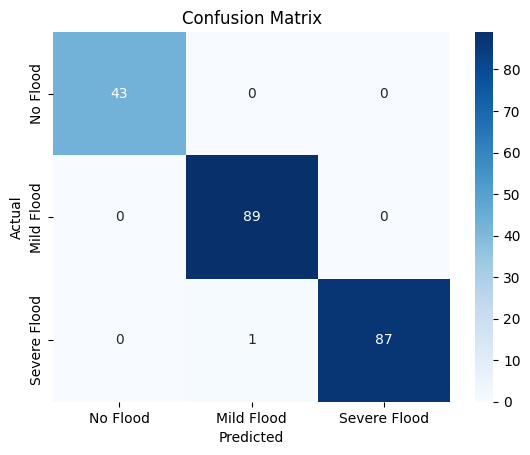

In [ ]:
cm = confusion_matrix(y_flood_test, y_flood_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Mild Flood','Severe Flood'], yticklabels=['No Flood', 'Mild Flood','Severe Flood'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

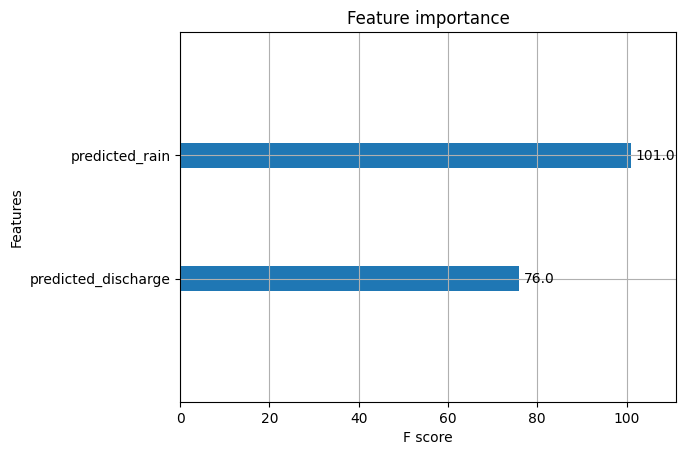

In [ ]:
xgb.plot_importance(xgb_flood)
plt.show()
